In [1]:
import pandas as pd
import numpy as np
import time
import os
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
BASE_DIR = os.path.dirname(os.path.abspath('__file__'))
DATA_DIR = os.path.join(BASE_DIR, 'data', 'featured', 'epl_matches_featured.csv')
MODEL_DIR = os.path.join(BASE_DIR, 'model')

In [3]:
df = pd.read_csv(DATA_DIR)

In [4]:
# dropping columns that should be unknown before an actual match
cols_to_drop = ['season','date','h_team','a_team','h_score', 'a_score', 'h_match_points', 'a_match_points']
df.drop( columns = cols_to_drop, inplace = True)

In [5]:
# Integer encoding
df['winner'] = np.where(df.winner == 'h', 2, np.where(df.winner == 'a', 1, 0))

In [6]:
#turning categorical into dummy vars
df_dum = pd.get_dummies(df)

In [7]:
np.random.seed(101)

In [8]:
df.columns

Index(['winner', 'h_odd', 'd_odd', 'a_odd', 'h_standing', 'a_standing',
       'ht_pts', 'ht_goals_for', 'ht_goals_against', 'at_pts', 'at_goals_for',
       'at_goals_against', 'h_ewm_points', 'h_ewm_goals_for',
       'h_ewm_goals_against', 'a_ewm_points', 'a_ewm_goals_for',
       'a_ewm_goals_against', 'h_vs_winrate', 'a_vs_winrate'],
      dtype='object')

In [9]:
X = df.drop(['winner'], axis=1)
y = df.winner.values

In [10]:
#splitting into train and test set to check which model is the best one to work on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [11]:
#scaling features
scaler = MinMaxScaler()

In [12]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [13]:
#creating models variable to iterate through each model and print result
models = [LogisticRegression(max_iter= 1000, multi_class = 'multinomial'),
RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier()]

In [14]:
names = ['Logistic Regression', 'Random Forest', 'Gradient Boost', 'KNN']

In [15]:
#loop through each model and print train score and elapsed time
for model, name in zip(models, names):
    start = time.time()
    scores = cross_val_score(model, X_train, y_train ,scoring= 'accuracy', cv=10)
    print(name, ":", "%0.3f, +- %0.3f" % (scores.mean(), scores.std()), " - Elapsed time: ", time.time() - start)

Logistic Regression : 0.537, +- 0.024  - Elapsed time:  0.9894213676452637
Random Forest : 0.517, +- 0.021  - Elapsed time:  6.600799083709717
Gradient Boost : 0.525, +- 0.027  - Elapsed time:  33.381160497665405
KNN : 0.425, +- 0.012  - Elapsed time:  0.3583202362060547


 Clf result : 0.538, +- 0.013 N_features : 5
 Clf result : 0.538, +- 0.009 N_features : 6
 Clf result : 0.535, +- 0.009 N_features : 7
 Clf result : 0.538, +- 0.012 N_features : 8
 Clf result : 0.539, +- 0.010 N_features : 9
 Clf result : 0.539, +- 0.009 N_features : 10
 Clf result : 0.534, +- 0.010 N_features : 11
 Clf result : 0.539, +- 0.005 N_features : 12
 Clf result : 0.538, +- 0.006 N_features : 13
 Clf result : 0.536, +- 0.007 N_features : 14
 Clf result : 0.536, +- 0.007 N_features : 15
 Clf result : 0.537, +- 0.003 N_features : 16
 Clf result : 0.537, +- 0.002 N_features : 17
 Clf result : 0.537, +- 0.008 N_features : 18
 Clf result : 0.538, +- 0.005 N_features : 19
 Clf result : 0.538, +- 0.005 N_features : 20
 Clf result : 0.538, +- 0.005 N_features : 21
 Clf result : 0.538, +- 0.005 N_features : 22
 Clf result : 0.538, +- 0.005 N_features : 23
 Clf result : 0.538, +- 0.005 N_features : 24
 Clf result : 0.538, +- 0.005 N_features : 25
 Clf result : 0.538, +- 0.005 N_feature

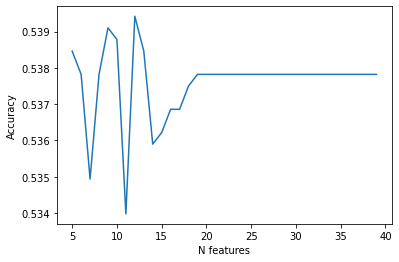

In [16]:
#Creating loop to test which set of features is the best one for Logistic Regression

acc_results = []
n_features = []

#best classifier on training data
clf = LogisticRegression(max_iter = 1000, multi_class = 'multinomial')

for i in range(5, 40):
    rfe = RFE(estimator = clf, n_features_to_select = i, step=1)
    rfe.fit(X, y)
    X_temp = rfe.transform(X)

    np.random.seed(101)

    X_train, X_test, y_train, y_test = train_test_split(X_temp,y, test_size = 0.2)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    start = time.time()
    scores = cross_val_score(clf, X_train, y_train ,scoring= 'accuracy', cv=5)
    print(" Clf result :", "%0.3f, +- %0.3f" % (scores.mean(), scores.std()), 'N_features :', i)
    acc_results.append(scores.mean())
    n_features.append(i)

plt.plot(n_features, acc_results)
plt.ylabel('Accuracy')
plt.xlabel('N features')
plt.show()


In [17]:
#getting the best 13 features from RFE
rfe = RFE(estimator = clf, n_features_to_select = 12, step=1)
rfe.fit(X, y)
X_transformed = rfe.transform(X)

np.random.seed(101)
X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, test_size = 0.2)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [18]:
#getting column names
featured_columns = pd.DataFrame(rfe.support_,
                            index = X.columns,
                            columns=['is_in'])

featured_columns = featured_columns[featured_columns.is_in == True].index.tolist()

#column importances for each class
importances_d = pd.DataFrame(np.exp(rfe.estimator_.coef_[0]),
                            index = featured_columns,
                            columns=['coef']).sort_values('coef', ascending = False)

importances_a = pd.DataFrame(np.exp(rfe.estimator_.coef_[1]),
                            index = featured_columns,
                            columns=['coef']).sort_values('coef', ascending = False)

importances_h = pd.DataFrame(np.exp(rfe.estimator_.coef_[2]),
                            index = featured_columns,
                            columns=['coef']).sort_values('coef', ascending = False)

In [19]:
#tuning logistic regression
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'fit_intercept': (True, False), 'solver' : ('newton-cg', 'sag', 'saga', 'lbfgs'), 'class_weight' : (None, 'balanced')}

gs = GridSearchCV(clf, parameters, scoring='accuracy', cv=3)
start = time.time()

#printing best fits and time elapsed
gs.fit(X_train,y_train)
print(gs.best_score_, gs.best_params_,  time.time() - start)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

0.5346153846153846 {'C': 1, 'class_weight': None, 'fit_intercept': True, 'solver': 'newton-cg'} 22.488422393798828


KNeighborsClassifier()

In [20]:
#testing models on unseen data 
tpred_lr = gs.best_estimator_.predict(X_test)
tpred_rf = rf.predict(X_test)
tpred_gb = gb.predict(X_test)
tpred_knn = knn.predict(X_test)

print(classification_report(y_test, tpred_lr, digits = 3))
print(classification_report(y_test, tpred_rf, digits = 3))
print(classification_report(y_test, tpred_gb, digits = 3))
print(classification_report(y_test, tpred_knn, digits = 3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       181
           1      0.549     0.545     0.547       246
           2      0.566     0.858     0.682       353

    accuracy                          0.560       780
   macro avg      0.372     0.468     0.410       780
weighted avg      0.430     0.560     0.481       780

              precision    recall  f1-score   support

           0      0.261     0.033     0.059       181
           1      0.529     0.557     0.543       246
           2      0.566     0.799     0.663       353

    accuracy                          0.545       780
   macro avg      0.452     0.463     0.421       780
weighted avg      0.484     0.545     0.485       780

              precision    recall  f1-score   support

           0      0.261     0.033     0.059       181
           1      0.515     0.610     0.559       246
           2      0.592     0.782     0.674       353

    accuracy        

In [21]:
#function to get winning odd value in simulation dataset
def get_winning_odd(df):
    if df.winner == 2:
        result = df.h_odd
    elif df.winner == 1:
        result = df.a_odd
    else:
        result = df.d_odd
    return result

In [22]:
#creating dataframe with test data to simulate betting winnings with models

test_df = pd.DataFrame(scaler.inverse_transform(X_test),columns =  featured_columns)
test_df['tpred_lr'] = tpred_lr
test_df['tpred_rf'] = tpred_rf
test_df['tpred_gb'] = tpred_gb
test_df['tpred_knn'] = tpred_knn

test_df['winner'] = y_test
test_df['winning_odd'] = test_df.apply(lambda x: get_winning_odd(x), axis = 1)

test_df['lr_profit'] = (test_df.winner == test_df.tpred_lr) * test_df.winning_odd * 100
test_df['rf_profit'] = (test_df.winner == test_df.tpred_rf) * test_df.winning_odd * 100
test_df['gb_profit'] = (test_df.winner == test_df.tpred_gb) * test_df.winning_odd * 100
test_df['knn_profit'] = (test_df.winner == test_df.tpred_knn) * test_df.winning_odd * 100

investment = len(test_df) * 100

lr_return = test_df.lr_profit.sum() - investment
rf_return = test_df.rf_profit.sum() - investment
gb_return = test_df.gb_profit.sum() - investment
knn_return = test_df.knn_profit.sum() - investment

profit = (lr_return/investment * 100).round(2)

print(f'''Logistic Regression return: ${lr_return}
Random Forest return: ${rf_return}
Gradient Boost return:  ${gb_return}
KNN return:  ${knn_return} \n
Logistic Regression model profit percentage : {profit} %
''')

Logistic Regression return: $-509.0
Random Forest return: $-2406.0
Gradient Boost return:  $595.0
KNN return:  $2093.0 

Logistic Regression model profit percentage : -0.65 %



In [23]:
#retraining final model on full data
gs.best_estimator_.fit(X_transformed, y)

#Saving model and features
model_data = pd.Series( {
    'model': gs,
    'features': featured_columns
} )

#saving model
pickle.dump(model_data, open(os.path.join(MODEL_DIR, "lr_model.pkl"), 'wb'))